# AtomAI-Based Analysis of HAADF/SEEBIC Images

This notebook leverages tools from the AtomAI python package to analyze a set of images. We have two concurrently acquired five-frame stacks of WSe2 sandwiched between layers of h-BN with graphene on top. One stack is the HAADF signal, the other is the SEEBIC signal.

For use of AtomAI please cite

@article{ziatdinov2021atomai,
  title={AtomAI: A Deep Learning Framework for Analysis of Image and Spectroscopy Data in (Scanning) Transmission Electron Microscopy and Beyond},
  author={Ziatdinov, Maxim and Ghosh, Ayana and Wong, Tommy and Kalinin, Sergei V.},
  journal={arXiv preprint arXiv:2105.07485},
  year={2021}
}

Workflow: Ondrej Dyck

Data Acquisition: Ondrej Dyck

Sample: Jawaher Ulmatlaq

Substrate: Jacob Swett

2022-10-07

In [ ]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import tifffile as tif
import cv2
from sklearn.cluster import KMeans

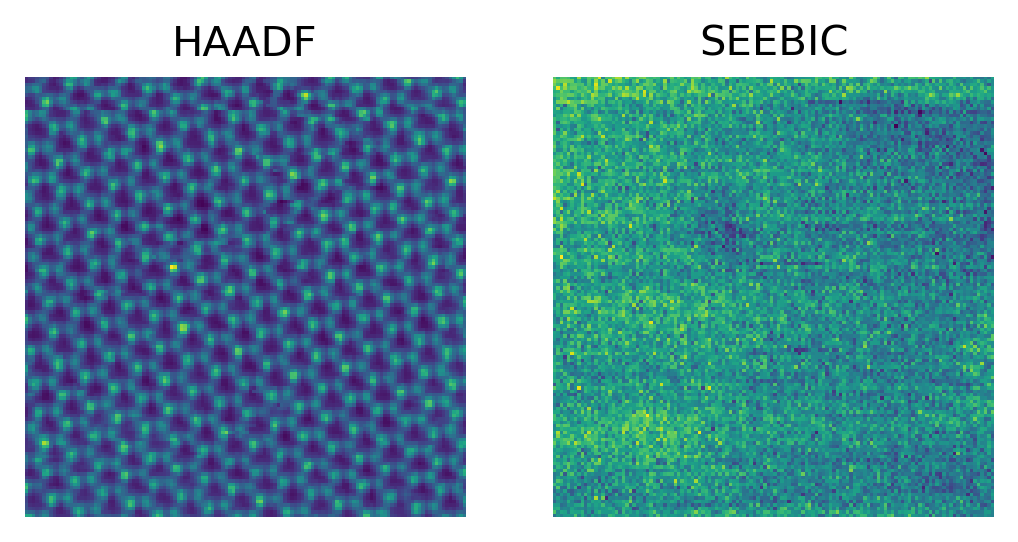

In [3]:
haadf_name = 'Recording_of_SuperScan_(HAADF).tif'
seebic_name = 'Recording_of_SuperScan_(Ext).tif'

# load data
haadf = tif.imread(haadf_name)
seebic = tif.imread(seebic_name)

# plot
fig, ax = plt.subplots(1,2, figsize=(5,10), facecolor='white', dpi=250)
ax[0].imshow(haadf[0])
ax[0].set_axis_off()
ax[0].set_title('HAADF')

ax[1].imshow(seebic[0])
ax[1].set_axis_off()
ax[1].set_title('SEEBIC')

basename = haadf_name.rsplit('.')[0]
plt.savefig(basename+'_HAADF_SEEBIC_comparison.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_HAADF_SEEBIC_comparison.svg', bbox_inches='tight')
plt.show()

### Calibrate the SEEBIC Signal

We would like to have the SEEBIC pixel values converted to pA. To do this we acquired a series of "images" with the e-beam off and applied a known voltage to the Nion SuperScan input with a Keithley power supply. The output from our transimpedance amplifier (TIA) is in the range $\pm$ 10 V so we applied $\pm$ 10 V with the Keithley in steps of 1 V to determine the conversion from pixel intensity to voltage and verify the linearity of the Nion SuperScan system. This proceedure was performed in a different notebook. The resulting linear relationship is

$$
I_{im} = mV + b\\
m = 0.07847\\
b = -0.00956
$$

Where $I_{im}$ is the observed image intensity, $V$ is the voltage applied and $m$ and $b$ are the result of the linear fit rounded to five decimal places.

We want to rescale the SEEBIC image according to 

$$
I_{pA} = \frac{I_{im} - b}{m}\times 10
$$

where $I_{pA}$ is the measured current in pA, the fraction is simply the image intensity converted to voltage, and the multiplicative constant comes from the fact that our TIA was operated with a gain of $10^{11}$ V/A and we want our result in pA, $10^{-12}$.

In [4]:
seebic = tif.imread(seebic_name) # reload the data here just in case this cell is run multiple times (scaling should only be applied once)

def intensity_to_pA(img):
    m = 0.07847
    b = -0.00956
    scaled_img = (img-b)/m * 10
    return scaled_img

seebic = intensity_to_pA(seebic)

print(f'Mean SEEBIC current {np.mean(seebic):0.1f} pA')


Mean SEEBIC current -1.7 pA


Next we want to find the atom positions in the HAADF image stack.

We will use a pretrained DCNN model that comes with AtomAI. I have not figured out how to load this without providing a path name even though presumably it is included with the AtomAI package. I downloaded the model from the AtomAI GitHub page [here](https://github.com/pycroscopy/atomai/blob/master/pretrained/G_MD.tar) and saved it in the working directory.

In [6]:
# load pretrained model
model = aoi.load_model("G_MD.tar")


# The model has an optimal pixel-to-feature ratio based on the training examples.
# Our data here is not optimal. We will interpolate to get more pixels.
rescale_dims = (512,512)
bighaadf = np.zeros((5,512,512))
bigseebic = np.zeros_like(bighaadf)
for i in range(np.shape(haadf)[0]):
    bighaadf[i] = cv2.resize(haadf[i], rescale_dims, interpolation=cv2.INTER_CUBIC)
    bigseebic[i] = cv2.resize(seebic[i], rescale_dims, interpolation=cv2.INTER_CUBIC)

# this also works but it doesn't do the cubic interpolation
#bighaadf = aoi.utils.img_resize(haadf, rescale_dims)
#bigseebic = aoi.utils.img_resize(seebic, rescale_dims)

# predict
# Note: resizing can be done by passing resize=rescale_dims as an argument here
# but we won't get back our resized image for plotting later.
nn_out, coords = model.predict(bighaadf, thresh=0.6) 

Batch 5/5
5 images were decoded in approximately 0.2563 seconds


We get back two objects:

`nn_out` is a numpy array containing the probabilities for each pixel being an atom. Since our original data was 5 frames, the first dimension is 5. The next two dimensions are the rescaled pixel dimensions that we specified in the previous cell. The fourth dimension is used for the possibility of spectroscopic data.

The `thresh` parameter is a threshold that is applied to `nn_out` to obtain blobs. The center of mass of these blobs is then taken as the atom positions. The default is 0.5 but we can adjust to whatever works well. 

In [7]:
np.shape(nn_out)

(5, 512, 512, 1)

The other object we get back, `coords`, is a python dict with the found atom positions. The keys are our frame numbers.

In [8]:
print(type(coords))

coords.keys()

<class 'dict'>


dict_keys([0, 1, 2, 3, 4])

In [9]:
# access the coordinates by passing a frame number
coords[0]

array([[  5.3       , 463.1       ,   0.        ],
       [  6.66666667,  52.125     ,   0.        ],
       [  7.6       , 443.96      ,   0.        ],
       ...,
       [504.78571429, 304.5       ,   0.        ],
       [506.7826087 , 173.39130435,   0.        ],
       [507.        , 415.13636364,   0.        ]])

Let's plot the output.

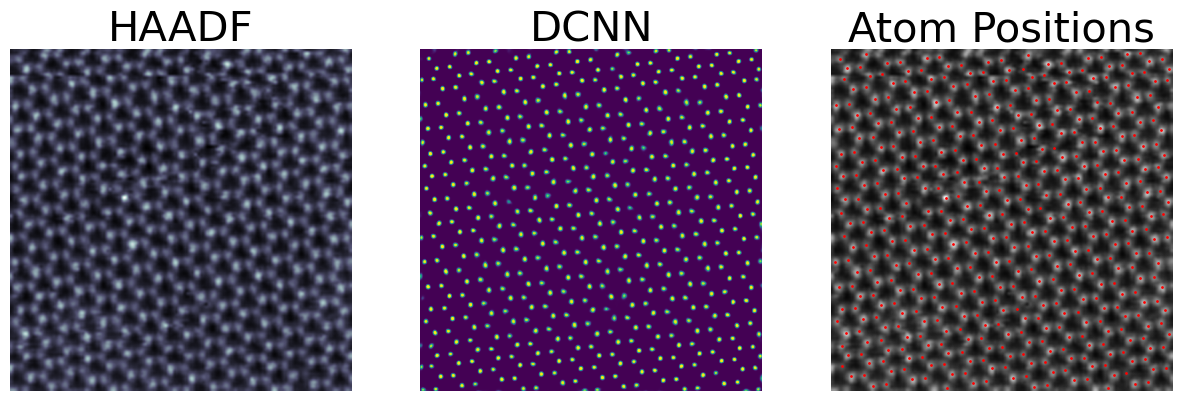

In [10]:
# pick which frame to plot
frame = 0

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), facecolor='white', dpi=100)

# plot HAADF image
ax[0].imshow(bighaadf[frame], cmap='bone')
ax[0].set_axis_off()
ax[0].set_title('HAADF', fontsize=30)

# plot DCNN output
ax[1].imshow(nn_out[frame,:,:,0])
ax[1].set_axis_off()
ax[1].set_title('DCNN', fontsize=30)

# overlay atoms
ax[2].imshow(bighaadf[frame], cmap='gray')
ax[2].scatter(coords[frame].T[1], coords[frame].T[0], s=1, color='red')
ax[2].set_axis_off()
ax[2].set_title('Atom Positions', fontsize=30)

plt.savefig(basename+'_DCNN.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_DCNN.svg', bbox_inches='tight')
plt.show()

Next, we get the image intensities at the atom positions in both the HAADF and SEEBIC images.

In [11]:
haadf_intensities = aoi.utils.get_intensities(coords, bighaadf, r=4)
seebic_intensities = aoi.utils.get_intensities(coords, bigseebic, r=4)

Now, we want to put all of this information into a Pandas DataFrame for easier manipulation, plotting, and storage.

In [12]:
# initialize the dataframe
atomsdf = pd.DataFrame(columns=['x', 'y', 'HAADF Intensity', 'SEEBIC Intensity', 'frame'])

# loop through the frames
index = np.arange(0,5,1)
for i, key, h_int, s_int in zip(index, coords.keys(), haadf_intensities, seebic_intensities):
    frame = [i]*np.shape(coords[key])[0] # create a vector containing the frame number that is as long as however many atoms we have
    x = coords[key].T[1] # get the x coordinates
    y = coords[key].T[0] # get the y coordinates

    # put data in dataframe
    data_tmp = pd.DataFrame({'x': x,
                            'y': y,
                            'HAADF Intensity': h_int,
                            'SEEBIC Intensity': s_int,
                            'frame': frame})
    
    # stack this onto our main dataframe
    atomsdf = pd.concat((atomsdf, data_tmp), axis = 0, ignore_index=True)

# create one more column with an id number
atomsdf['atom_id'] = atomsdf.index

Let's have a look at the DataFrame

In [13]:
atomsdf

,x,y,HAADF Intensity,SEEBIC Intensity,frame,atom_id
0,463.1,5.3,0.050556,-1.834587,0,0
1,52.125,6.666667,0.060315,-1.598996,0,1
2,443.96,7.6,0.070714,-1.859944,0,2
3,294.884615,8.153846,0.062678,-1.644145,0,3
4,162.32,10.88,0.055698,-1.493,0,4
...,...,...,...,...,...,...
2371,39.4,503.04,0.054416,-1.629138,4,2371
2372,279.95,503.1,0.060226,-1.28239,4,2372
2373,18.6,504.04,0.063739,-1.704137,4,2373
2374,260.833333,506.0,0.06508,-1.610015,4,2374


### Intensity Histogram
Now let's plot a histogram of the atom intensities. We want to separate the W from the Se atoms.

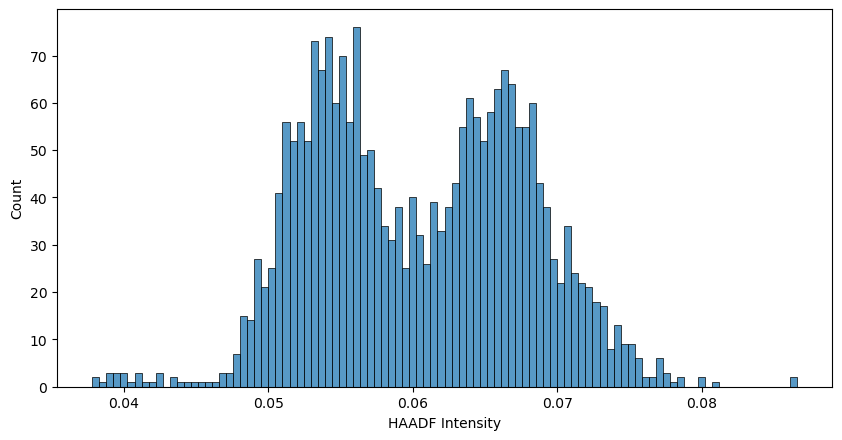

In [14]:
fig, ax = plt.subplots(1, figsize=(10,5), facecolor='white', dpi=100)
sns.histplot(data=atomsdf, x='HAADF Intensity', bins=100, ax=ax)
plt.show()

### Tiling
We have two distinct peaks. We could try fitting Gaussians to the two peaks but there is significant overlap and we would have to try to decide between the two for many atoms in the middle. Instead, let's try k-means clustering based on image tiles. The idea here is that an image tile will contain information about the local structure in addition to the intensity (as well as neighbor intensities) which should be a much more robust set of features for discriminating between W and Se lattice sites.

In [15]:
# create tiles
width = 50
tiles, tile_coords, tile_frame = aoi.utils.img.extract_subimages(bighaadf, coords, width) # HAADF
stiles, stile_coords, stile_frame = aoi.utils.img.extract_subimages(bigseebic, coords, width) # SEEBIC

Let's plot a few of the tiles.

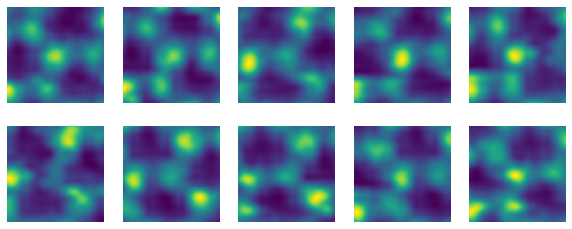

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), facecolor='white')
for i, ax in zip(range(10), np.ravel(ax)):
    ax.imshow(tiles[i])
    ax.set_axis_off()

plt.savefig(basename+'_example_tiles.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_example_tiles.svg', bbox_inches='tight')
plt.show()

These are not in the same order as what we have in our DataFrame and we want to be able to associate each tile with a specific entry in the DataFrame. So, we need to use the `tile_coords` and `tile_frame` to uniquely identify each tile using the atom_id.

In [17]:
# make a dict where we will store ids and tiles
tile_dict = {}

# loop through all our tiles, coordinates, and frames and match up the frames and coordinates with those in the dataframe
for s, t, c, f in zip(stiles, tiles, tile_coords, tile_frame):

    # get the part of the dataframe associated with that image frame
    subdf = atomsdf[atomsdf['frame']==f]

    # we want to match up the x and y coordinates
    condition = (subdf['x']==c[1]) & (subdf['y']==c[0])

    # get the atom id associated with that coordinate
    id = subdf[condition]['atom_id']

    # store the atom id and tile in the dict
    tile_dict[id.values[0]] = [t, s]

    # this dict turned out not to be especially helpful or well structured


Atoms at the edge of the image will have tiles that run off the edge. For this reason, atoms too close to the edge were automatically excluded from the tiling procedure. Thus, we do not have tiles for every atom in the DataFrame.

To use k-means clustering we need a 1D feature vector. Our tiles are 2D so we will flatten each of them into a vector.

In [18]:
# this format ended up easier to work with than the dictionary in the previous cell
tile_array = np.zeros((len(list(tile_dict.keys())), width*width))
stile_array = np.zeros((len(list(tile_dict.keys())), width*width))
for i, key in enumerate(list(tile_dict.keys())):
    tile_array[i] = np.ravel(tile_dict[key][0])
    stile_array[i] = np.ravel(tile_dict[key][1])

We now have 50x50 pixel tiles flattened into 1x2500 vectors stacked into a single array (well, two arrays, one for the HAADF tiles and the other for the SEEBIC tiles).

The columns, x-dimension, are the features, flattened tiles. The rows, y-dimension, are the different examples.
|         |Feature 1|Feature 2|Feature 3| ... |Feature n|
|:-------:|:-------:|:-------:|:-------:|:---:|:-------:|
|Tile 1 ->|val      |val      |val      |...  |val      |
|Tile 2 ->|val      |val      |val      |...  |val      |
|Tile 3 ->|val      |val      |val      |...  |val      |
|...      |...      |...      |...      |...  |...      |
|Tile n ->|val      |val      |val      |...  |val      |

The k-means clustering implementation will treat any 2D array passed to it as though each row is a single n-dimensional data point (n being the number of features that describe the data point). The labels it passes back correspond to the classification/group number it 'thinks' that row belongs to. Here, our features are just the intensities of the tiles strung out in a sequence. Note, though that the sequence is not random, it is structured almost the same as the original tile and, importantly, tiles that looked similar in 2D will look similar after being raveled down to 1D. This is what we're relying on to give us nicely separated clusters. Also of note: because this clustering is happening in a 2500 dimensional space we can't easily visualize the clusters like one can do in 1D, 2D and 3D clustering. What we will end up doing instead is plotting the color coded labels back on our image to prove to ourselves that it actually worked.

### K-Means Clustering
Now we want to do k-means clustering on these tiles.

In [19]:
# perform clustering based on the tiles
clusters = 2 # <== we want two clusters to discriminate between W and Se lattice sites
kmodel = KMeans(n_clusters=clusters, random_state=42) 
km = kmodel.fit(tile_array)

# create sub dataframe for atoms that have tiles
ind = list(tile_dict.keys())
atomsdf_sub = atomsdf.iloc[ind].copy()

atomsdf_sub['k-means labels'] = km.labels_
atomsdf_sub.index = np.arange(len(atomsdf_sub))

### Visualize Classifications
Now let's replot our histogram using the k-means label as the hue.

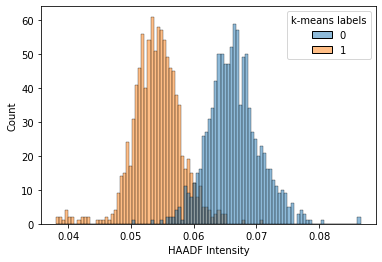

In [20]:
sns.histplot(data=atomsdf_sub, x='HAADF Intensity', hue='k-means labels', bins=100)
plt.show()

The 0 and 1 labels are arbitrary so based on the inspection here we want to assign a more meaningful label. For this image, label 0 corresponds to W and label 1 corresponds to Se-Se.

In [21]:
# create labels based on prior cell execution (i.e. we know what the k-means labels correspond to)
temp = np.array(['null']*len(atomsdf_sub), np.dtype(('U', 10)))
zero_ind = atomsdf_sub[atomsdf_sub['k-means labels']==0].index
one_ind = atomsdf_sub[atomsdf_sub['k-means labels']==1].index

# Decide which k-means label is W and which is Se-Se. W will be the brighter/leftmost peak.
zero_mean = atomsdf_sub[atomsdf_sub["k-means labels"]==0]["HAADF Intensity"].mean()
one_mean = atomsdf_sub[atomsdf_sub["k-means labels"]==1]["HAADF Intensity"].mean()

if zero_mean > one_mean:
    temp[zero_ind] = 'W'
    temp[one_ind] = 'Se-Se'
else:
    temp[zero_ind] = 'Se-Se'
    temp[one_ind] = 'W'

# put in dataframe
atomsdf_sub['Type'] = temp

Now let's replot the histogram with proper labels and publication ready format.

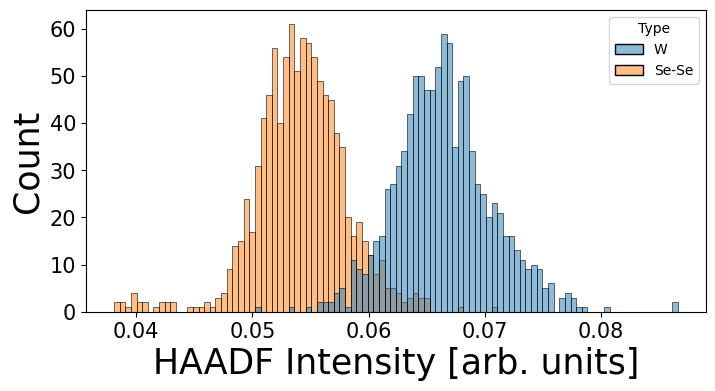

In [29]:
fig, ax = plt.subplots(1, figsize=(8,4), facecolor='white', dpi=100)
sns.histplot(data=atomsdf_sub, x='HAADF Intensity', hue='Type', bins=100, ax=ax)
ax.set_xlabel('HAADF Intensity [arb. units]', fontsize=25)
ax.set_ylabel('Count', fontsize=25)
ax.tick_params(labelsize=15)
plt.savefig(basename+'_classified_histogram.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_classified_histogram.svg', bbox_inches='tight')
plt.show()

Next let's plot all the HAADF images with a classification overlay.

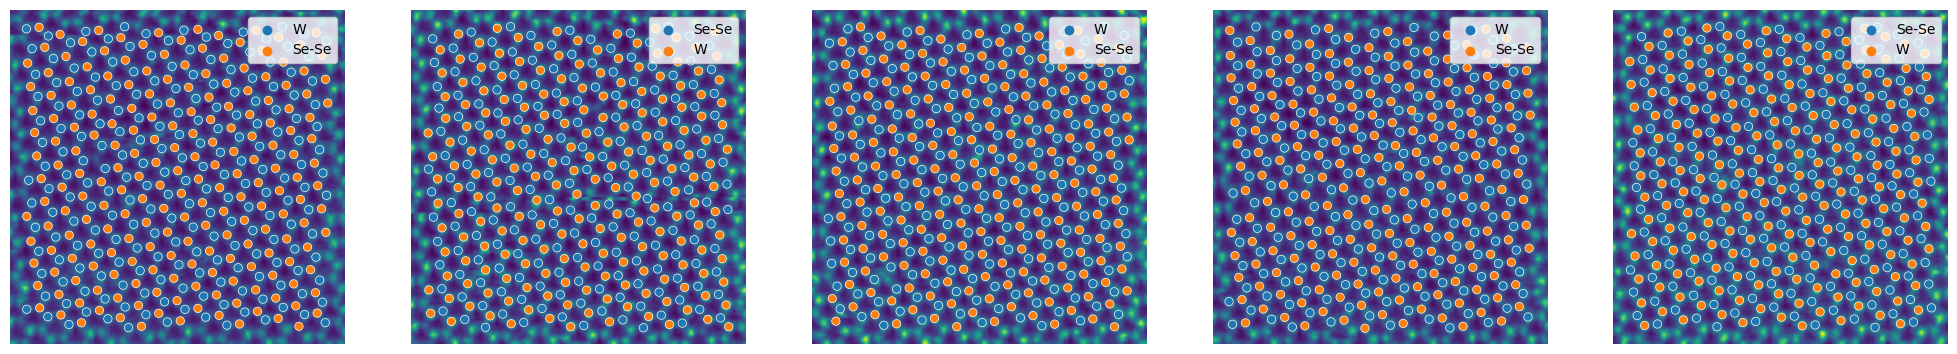

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,5), facecolor='white', dpi=100)
for i, axis in enumerate(np.ravel(ax)):
    axis.imshow(bighaadf[i])
    p = sns.scatterplot(data=atomsdf_sub[atomsdf_sub['frame']==i], x='x', y='y', hue='Type', ax=axis)
    p.legend(loc="upper right")
    axis.set_axis_off()

plt.savefig(basename+'_classified_HAADF.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_classified_HAADF.svg', bbox_inches='tight')
plt.show()

### Mean Response
Now we want to generate an average response of W and Se-Se from both the HAADF image and the SEEBIC image.

In [24]:
# get indices for Se-Se and W atoms
se_index = atomsdf_sub[atomsdf_sub['Type']=='Se-Se'].index
w_index = atomsdf_sub[atomsdf_sub['Type']=='W'].index

# get mean response from HAADF and SEEBIC images
haadf_w = np.mean(tile_array[w_index.astype(int)], axis=0).reshape(width, width)
haadf_se = np.mean(tile_array[se_index.astype(int)], axis=0).reshape(width, width)
seebic_w = np.mean(stile_array[w_index.astype(int)], axis=0).reshape(width, width)
seebic_se = np.mean(stile_array[se_index.astype(int)], axis=0).reshape(width, width)

Plot the mean response.

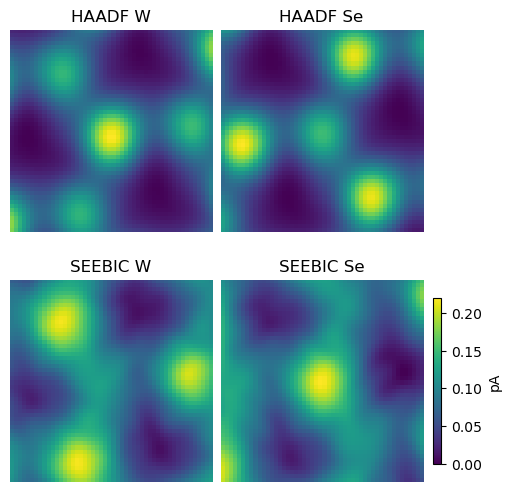

In [30]:
from PIL import Image
# here we are rescaling the SEEIBC average minimum value to be set to zero
min_val = np.min([np.min(seebic_w), np.min(seebic_se)])
seebic_w_new = seebic_w-min_val
seebic_se_new = seebic_se-min_val


# plotting
fig, ax = plt.subplots(2,2, figsize=(5,5), facecolor='white', dpi=100, constrained_layout=True)

tilenames = [haadf_w, haadf_se, seebic_w_new, seebic_se_new]
labels = ['HAADF W', 'HAADF Se', 'SEEBIC W', 'SEEBIC Se']
for axis, tile, label in zip(np.ravel(ax), tilenames, labels):
    if 'SEEBIC' in label:
            low = min(np.min(seebic_w_new), np.min(seebic_se_new))
            high = max(np.max(seebic_w_new), np.max(seebic_se_new))
            a = axis.imshow(tile, vmin=low, vmax=high)
            if 'SEEBIC Se' in label:
                cbar = plt.colorbar(a, ax=axis, shrink=.7)
                cbar.set_label('pA')
            
    else:
        axis.imshow(tile)
    
    axis.set_title(label)
    axis.set_axis_off()


plt.savefig(basename+'_mean_response.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_mean_response.svg', bbox_inches='tight')
plt.show()

We also want a histogram of the SEEBIC intensities. Now that we have our rescaling factor we can generate it so that it matches the intensities of the images.

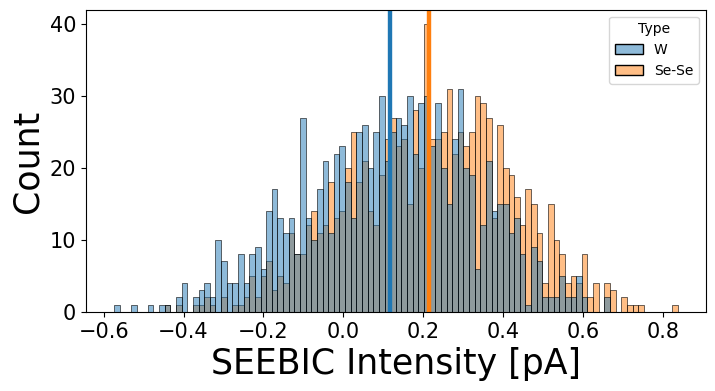

In [26]:
atomsdf_sub['Scaled SEEBIC Intensity'] = atomsdf_sub['SEEBIC Intensity']-min_val
wmean = atomsdf_sub[atomsdf_sub['Type']=='W']['Scaled SEEBIC Intensity'].mean()
semean = atomsdf_sub[atomsdf_sub['Type']=='Se-Se']['Scaled SEEBIC Intensity'].mean()
wmean_error = atomsdf_sub[atomsdf_sub['Type']=='W']['Scaled SEEBIC Intensity'].sem()
semean_error = atomsdf_sub[atomsdf_sub['Type']=='Se-Se']['Scaled SEEBIC Intensity'].sem()

cols = sns.color_palette()

fig, ax = plt.subplots(1, figsize=(8,4), facecolor='white', dpi=100)
sns.histplot(data=atomsdf_sub, x='Scaled SEEBIC Intensity', hue='Type', bins=100, ax=ax)
ax.set_xlabel('SEEBIC Intensity [pA]', fontsize=25)
ax.set_ylabel('Count', fontsize=25)
ax.tick_params(labelsize=15)

# Show mean standard error using bars
ax.axvspan(wmean-wmean_error/2, wmean+wmean_error/2, color=cols[0], alpha=1)
ax.axvspan(semean-semean_error/2, semean+semean_error/2, color=cols[1], alpha=1)

plt.savefig(basename+'_classified_SEEBIC_histogram.png', bbox_inches='tight', dpi=200)
#plt.savefig(basename+'_classified_SEEBIC_histogram.svg', bbox_inches='tight')
plt.show()

Finally, let's save the DataFrame as a csv in case we want to do something else with the extracted data.

In [27]:
atomsdf_sub.to_csv(basename+'_data.csv', index=False) # index=False doesn't store the row numbers

# can be read back in using pd.read_csv(file_name)